# LAB4 - TensorFlow Lite
ver: 3

Przedmiot: _Sztuczna Inteligencja w Systemach Informatycznych_

Autor: Tomasz Szydło

kontakt: tszydlo@agh.edu.pl


## Wprowadzenie

Celem zajęć jest analiza działania konwersji sieci neuronowych do postaci możliwej do uruchomienia na urządzeniach o ograniczonych zasobach. W czasie zajęć będzie wykorzystywany zbiór Fashion MNIST, który zawiera 60000 obrazków w 10 kategoriach:

https://github.com/zalandoresearch/fashion-mnist


https://www.tensorflow.org/datasets/catalog/fashion_mnist


### Środowisko pracy - Google Codelab

https://codelabs.developers.google.com/?cat=Machine+Learning



In [1]:
try:
  %tensorflow_version 2.x
except:
  pass

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
import tensorflow as tf
from keras.datasets import mnist, fashion_mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, AveragePooling2D, MaxPooling2D

from keras.utils import to_categorical

import numpy as np
import matplotlib.pyplot as plt
import pathlib

import time

print(tf.__version__)

2.15.0


Przygotuj zbiór testowy. Zbiór fashion_mnist nie posiada słownych opisów klas.

In [3]:
nb_classes = 10
class_names = ['T-shirt_top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

#(X_train, y_train), (X_test, y_test) = mnist.load_data()
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
print("X_train original shape", X_train.shape)
print("y_train original shape", y_train.shape)

4422102/4422102 [==============================] - 1s 0us/step
X_train original shape (60000, 28, 28)
y_train original shape (60000,)


Wypisz ilość elementów w zbiorze uczącym i testowym.





In [4]:
print(X_test)
print(X_train)

print(len(list(X_test)))
print(len(list(X_train)))

[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ...

**TODO** Zmień poniższy kod tak by wyświetlić 10 przykładowych obrazków - po jednym z każdej klasy.

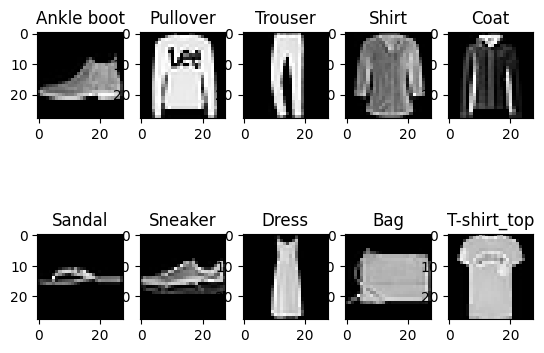

In [5]:
labels, j = [], 1
for i in range(20):
    plt.subplot(2,5,j)
    if class_names[y_test[i]] not in labels:
      plt.imshow(X_test[i], cmap='gray', interpolation='none')
      labels.append(class_names[y_test[i]])
      j += 1
    plt.title("{}".format(class_names[y_test[i]]))

Sieć neuronowa przyjmuje na wejściu obrazek z jednym kanałem - poziomem jasności, więc konieczne jest przekształcenie danych wejściowych, aby każdy obraz 28 x 28 stał się macierzą 28 x 28 x 1.

Skalujemy również dane wejściowe w zakresie [0–1] zamiast [0–255]

In [6]:
X_train = X_train.reshape(60000, 28,28,1)
X_test = X_test.reshape(10000, 28,28,1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

print(nb_classes)

Training matrix shape (60000, 28, 28, 1)
Testing matrix shape (10000, 28, 28, 1)
10


Zmodyfikuj macierze wyjść korzystając z techniki One Hot Encoding, tj.

```
0 -> [1, 0, 0, 0, 0, 0, 0, 0, 0]
1 -> [0, 1, 0, 0, 0, 0, 0, 0, 0]
2 -> [0, 0, 1, 0, 0, 0, 0, 0, 0]
```
itp.

In [7]:
Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)

Wielowarstwowa sieć konwolucyjna do klasyfikacji ubrań.

In [8]:
model = Sequential([
  Conv2D(16, 3, activation='relu', input_shape=(28, 28, 1)),
  MaxPooling2D(),
  Conv2D(32, 3, activation='relu'),
  Flatten(),
  Dense(64, activation='relu'),
  Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 32)        4640      
                                                                 
 flatten (Flatten)           (None, 3872)              0         
                                                                 
 dense (Dense)               (None, 64)                247872    
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                        

W celu skrócenia czasu uczenia sieci wskazane jest użycie GPU.

In [10]:
model.fit(X_train, Y_train,
          batch_size=32, epochs=10,
          verbose=1,
          validation_data=(X_test, Y_test))

Epoch 1/10
1875/1875 [==============================] - 12s 4ms/step - loss: 0.4437 - accuracy: 0.8389 - val_loss: 0.3578 - val_accuracy: 0.8634
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2921 - accuracy: 0.8935 - val_loss: 0.2898 - val_accuracy: 0.8955
Epoch 3/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2460 - accuracy: 0.9111 - val_loss: 0.2652 - val_accuracy: 0.9025
Epoch 4/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2108 - accuracy: 0.9219 - val_loss: 0.2441 - val_accuracy: 0.9129
Epoch 5/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1827 - accuracy: 0.9314 - val_loss: 0.2520 - val_accuracy: 0.9104
Epoch 6/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1624 - accuracy: 0.9406 - val_loss: 0.2450 - val_accuracy: 0.9137
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1412 - accuracy: 0.9486 - val_loss: 0.2603 - val_accuracy

# Zapisywanie NN

Szczegółowe informacje dotyczące zapisywania modeli TensorFlow dostępne pod linkiem:

https://www.tensorflow.org/tutorials/keras/save_and_load

In [11]:
export_dir = 'saved_model'
model.save(export_dir)

Po zapisaniu modelu należy kliknąć "Refresh" po lewej stronie w zakładce "Files". W katalogu "saved_model" znajduje się zapisany model.

# Export do TFLite

Narzędzie `TFLiteConverter` zostanie wykorzystane do konwersji modelu NN do formatu akceptowanego przez TFLite tzn. `flat protocol buffers`.

https://www.tensorflow.org/lite/guide/get_started#2_convert_the_model_format

Wygenerowany model `"model-base.tflite"` operuje na wagach typu `float32`.

In [12]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

with open("model-base.tflite", "wb") as f:
    f.write(tflite_model)

Po zapisaniu modelu należy kliknąć "Refresh" po lewej stronie w zakładce "Files".

Kolejnym krokiem jest kwantyzacja wag modelu z 32 bitowych liczb rzeczywistych do liczb 8 bitowych. Proces kwantyzacji jest uruchamiany na gotowym, wyuczonym modelu. Należy wybrać profil optymaliacji `tf.lite.Optimize.DEFAULT`.



In [13]:
  converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)

  #TODO ustaw odpowiedni rodzaj optymalizacji sieci neuronowej

  converter.optimizations = [tf.lite.Optimize.DEFAULT]

  tflite_model = converter.convert()

  with open("model-quant.tflite", "wb") as f:
    f.write(tflite_model)


Po zapisaniu modelu należy kliknąć "Refresh" po lewej stronie w zakładce "Files".

In [14]:
# funkcja testujaca model z wykorzystaniem interpretera TFLite
# TODO zmodyfikuj funkcje tak by zwracala (accuracy, latency)

import time
from statistics import mean

def test_model_accuracy(tflite_model):
  # Load TFLite model and allocate tensors.

  interpreter = tf.lite.Interpreter(model_path=tflite_model)
  interpreter.allocate_tensors()

  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]
  accuracy, all = 0, 0
  time_list = []

  for img, label in zip(X_test, y_test):
    all += 1
    interpreter.set_tensor(input_index, [img])

    start_time = time.time()
    interpreter.invoke()
    end_time = time.time()
    time_list.append(end_time - start_time)

    prediction = interpreter.get_tensor(output_index)
    label_is = np.argmax(prediction, axis=-1)[0]
    label_should_be = label
    if label_is == label_should_be:
      accuracy += 1
    #print("Label is {} should be {}.".format(label_is, label_should_be))

  accuracy /= all
  latency = mean(time_list) * 1000
  return (accuracy, latency)


In [15]:
#TODO tylko na potrzeby testowania - do usuniecia
print(test_model_accuracy("model-base.tflite"))

#TODO tylko na potrzeby testowania - do usuniecia
print(test_model_accuracy("model-quant.tflite"))


(0.9172, 0.05987904071807861)
(0.9173, 0.07861785888671875)


<BarContainer object of 2 artists>

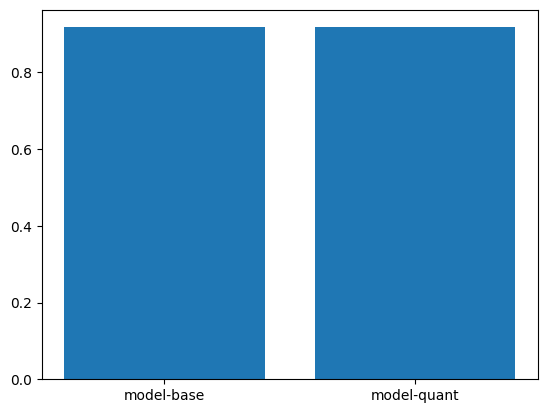

In [17]:
# porównaj dokladnosc wynikowych modeli TFLite
# TODO wyniki przedstaw na wykresie słupkowym (jeden slupek dla model-base, a drugi dla model-quant)
plt.bar(['model-base', 'model-quant'], (test_model_accuracy("model-base.tflite")[0], test_model_accuracy("model-quant.tflite")[0]))

<BarContainer object of 2 artists>

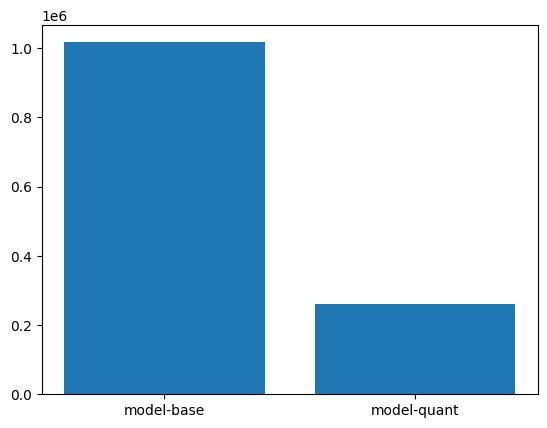

In [19]:
# porównaj rozmiar wynikowych modeli TFLite
# TODO wyniki przedstaw na wykresie słupkowym (jeden slupek dla model-base, a drugi dla model-quant)
sizes = [pathlib.Path('model-base.tflite').stat().st_size, pathlib.Path('model-quant.tflite').stat()
    .st_size]
plt.bar(['model-base', 'model-quant'], sizes)

<BarContainer object of 2 artists>

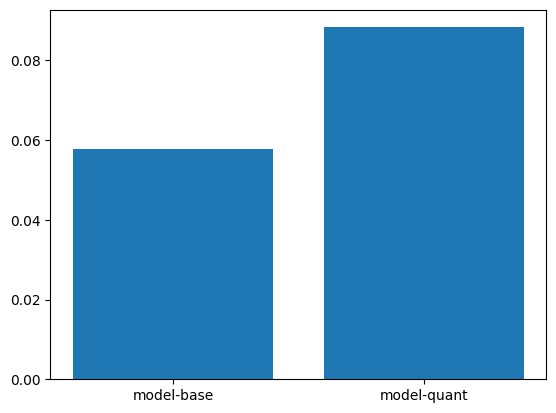

In [23]:
# porównaj czas dzialania wynikowych modeli TFLite
# TODO wyniki przedstaw na wykresie słupkowym (jeden slupek dla model-base, a drugi dla model-quant)
plt.bar(['model-base', 'model-quant'], (test_model_accuracy("model-base.tflite")[1], test_model_accuracy("model-quant.tflite")[1]))

 # Wnioski

**TODO** przedstaw wnioski z przeprowadzonych eksperymentów
**TODO** dlaczego czasy działania modeli są różne?

Obie wersje modelu, bazowa i kwantyzowana, wykazują porównywalną dokładność. Model kwantyzowany jest znacznie mniejszy w porównaniu do modelu bazowego. Model bazowy działa nieco szybciej niż model kwantyzowany. Wynika to przede wszystkim z kształtu warstw i architektury wykorzystanego procesora.